In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


Features being used: ['Sales per customer', 'Benefit per order', 'Product Category Id', 'Product Name', 'Customer Segment', 'Customer Country', 'Customer City', 'Shipping Mode', 'Order Status', 'Delivery Status', 'Late_delivery_risk']


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-23-f31b41be1169>:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
<ipython-input-23-f31b41be1169>:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 6892.2446, Test Loss: 9707.9658, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [2/50], Train Loss: 338.8533, Test Loss: 4977.3525, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [3/50], Train Loss: 456.4955, Test Loss: 4795.7998, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [4/50], Train Loss: 435.7197, Test Loss: 4574.8398, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [5/50], Train Loss: 490.1649, Test Loss: 4474.0928, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [6/50], Train Loss: 321.7180, Test Loss: 4235.8232, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [7/50], Train Loss: 362.5353, Test Loss: 3994.1604, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [8/50], Train Loss: 147.9608, Test Loss: 4351.3174, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [9/50], Train Loss: 265.1256, Test Loss: 3921.1914, Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch [10/50], Train Loss: 290.6248, Test Loss: 3492.6780, Trai

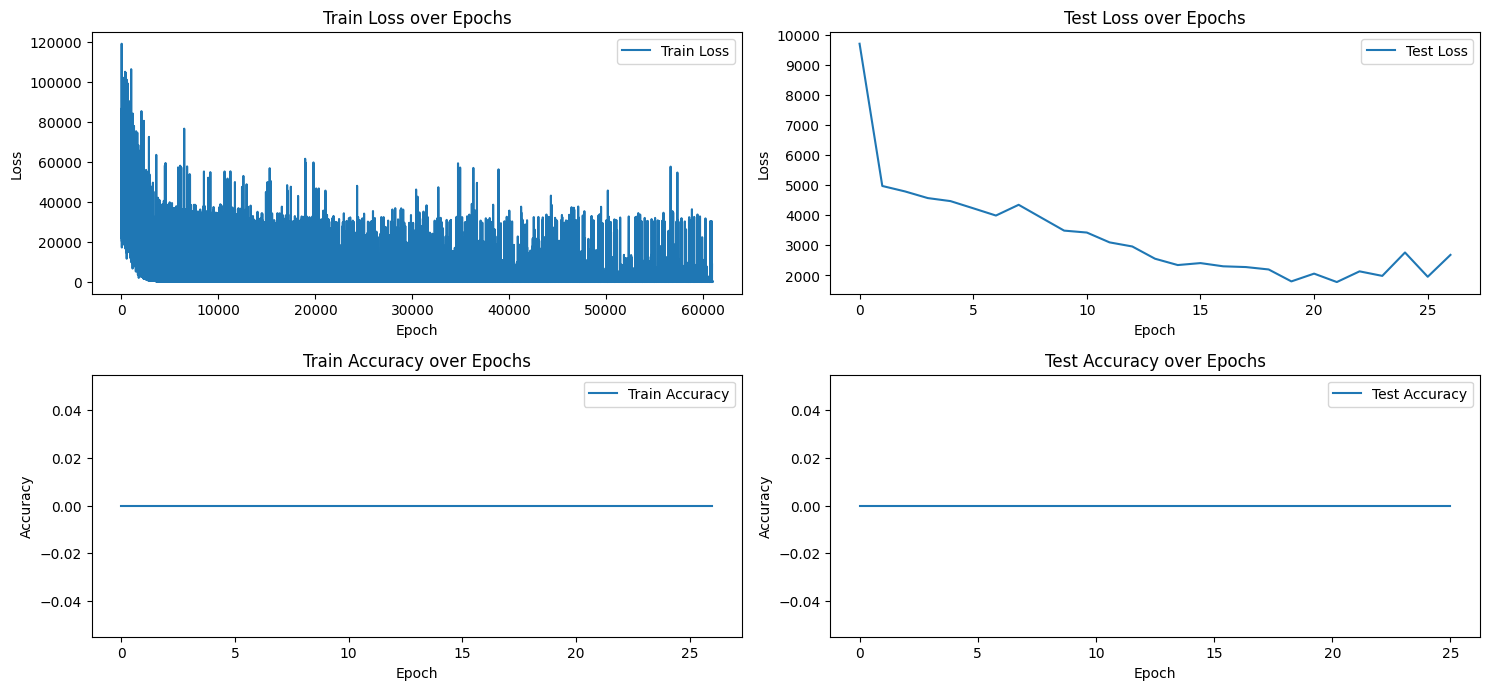

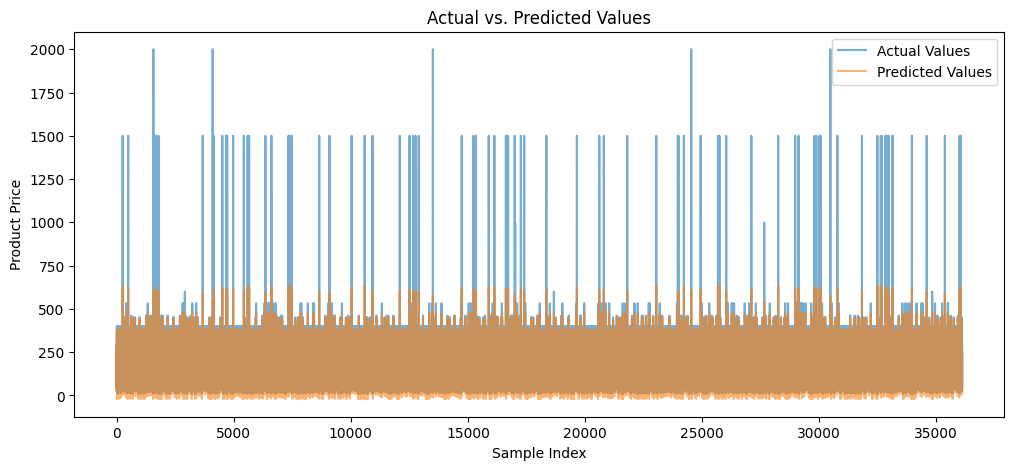

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.sparse import issparse
from torch.cuda.amp import autocast, GradScaler

# Load dataset
file_path = '/content/sample_data/DataCoSupplyChainDatasetCleaned.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preprocess the dataset
available_features = df.columns.tolist()
features = [
    'Sales per customer', 'Benefit per order', 'Product Category Id',
    'Product Name', 'Product Description', 'Customer Segment', 'Customer Country',
    'Customer City', 'Order Quantity', 'Shipping Mode', 'Order Status',
    'Delivery Status', 'Late_delivery_risk'
]

# Ensure only available features are included
features = [f for f in features if f in available_features]
target = 'Product Price'

# Separate numerical and categorical features
numerical_features = [f for f in features if df[f].dtype in ['int64', 'float64']]
categorical_features = [f for f in features if df[f].dtype == 'object']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Apply the preprocessing pipeline
print("Features being used:", features)
X = preprocessor.fit_transform(df[features])

# Convert sparse matrix to dense if needed
if issparse(X):
    X = X.toarray()

# Ensure the target column is available in the DataFrame
if target in df.columns:
    y = df[target].values
else:
    raise KeyError(f"Target column '{target}' not found in the DataFrame. Available columns: {df.columns.tolist()}")

# 4. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to GPU tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).view(-1, 1)

# Set batch size
batch_size = 64

# Transformer Model with Self-Attention
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_heads, num_layers, output_dim, dropout_rate):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_fc(x))
        x = self.dropout(x)
        x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)
        x = self.output_fc(x)
        return x

# Model Parameters
input_dim = X_train.shape[1]
hidden_dim = 32
n_heads = 4
num_layers = 2
output_dim = 1
dropout_rate = 0.5

# Initialize model
model = TransformerModel(input_dim, hidden_dim, n_heads, num_layers, output_dim, dropout_rate).to(device)

# 5. Train the Model Using Adam Optimizer
num_epochs = 50
train_loss_per_epoch = []
test_loss_per_epoch = []
train_accuracy_per_epoch = []
test_accuracy_per_epoch = []
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scaler = GradScaler()  # Mixed precision training

train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train_tensor.cpu(), y_train_tensor.cpu())), batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=list(zip(X_test_tensor.cpu(), y_test_tensor.cpu())), batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=0)

# Training Loop
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred_train = model(X_batch)
            train_loss = nn.MSELoss()(y_pred_train, y_batch)
        scaler.scale(train_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss_per_epoch.append(train_loss.item())

        # Calculate training accuracy
        train_pred_labels = (y_pred_train > 0.5).float()
        train_correct += (train_pred_labels == y_batch).sum().item()
        train_total += y_batch.size(0)
    train_accuracy = train_correct / train_total
    train_accuracy_per_epoch.append(train_accuracy)

    # Evaluation on test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        test_loss = nn.MSELoss()(y_pred_test, y_test_tensor)
        test_loss_per_epoch.append(test_loss.item())

        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Calculate testing accuracy
        test_pred_labels = (y_pred_test > 0.5).float()
        test_correct += (test_pred_labels == y_test_tensor).sum().item()
        test_total += y_test_tensor.size(0)
    test_accuracy = test_correct / test_total
    test_accuracy_per_epoch.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 6. Predict Actual vs. Predicted Values
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_actual = y_test_tensor.cpu().numpy()

# 7. Visualize the Results
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.plot(train_loss_per_epoch, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(test_loss_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_accuracy_per_epoch, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy over Epochs')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(test_accuracy_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Actual vs Predicted Plot
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Values', alpha=0.6)
plt.plot(y_pred, label='Predicted Values', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel(target)
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Features being used: ['Sales per customer', 'Benefit per order', 'Product Category Id', 'Product Name', 'Customer Segment', 'Customer Country', 'Customer City', 'Shipping Mode', 'Order Status', 'Delivery Status', 'Late_delivery_risk']


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-24-c2f4c8dba15b>:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 3333.0559, Test Loss: 8278.2988, Train R^2: 0.5654, Test R^2: 0.5746


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/50], Train Loss: 319.6925, Test Loss: 4384.8413, Train R^2: 0.7617, Test R^2: 0.7747


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/50], Train Loss: 729.9803, Test Loss: 4414.9487, Train R^2: 0.7614, Test R^2: 0.7731


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/50], Train Loss: 345.0578, Test Loss: 4563.5781, Train R^2: 0.7545, Test R^2: 0.7655


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/50], Train Loss: 222.5731, Test Loss: 4324.2178, Train R^2: 0.7671, Test R^2: 0.7778


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/50], Train Loss: 798.9658, Test Loss: 4025.8582, Train R^2: 0.7833, Test R^2: 0.7931


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/50], Train Loss: 345.0674, Test Loss: 4127.7295, Train R^2: 0.7783, Test R^2: 0.7879


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/50], Train Loss: 2976.2273, Test Loss: 4050.3374, Train R^2: 0.7830, Test R^2: 0.7919


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/50], Train Loss: 216.1197, Test Loss: 3692.3538, Train R^2: 0.8024, Test R^2: 0.8103


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/50], Train Loss: 167.5040, Test Loss: 3210.9885, Train R^2: 0.8280, Test R^2: 0.8350


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/50], Train Loss: 197.1553, Test Loss: 2954.5608, Train R^2: 0.8413, Test R^2: 0.8482


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/50], Train Loss: 377.0389, Test Loss: 2529.8911, Train R^2: 0.8645, Test R^2: 0.8700


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/50], Train Loss: 17230.4492, Test Loss: 2197.6184, Train R^2: 0.8823, Test R^2: 0.8871


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/50], Train Loss: 272.4898, Test Loss: 2012.6267, Train R^2: 0.8912, Test R^2: 0.8966


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/50], Train Loss: 447.0056, Test Loss: 2300.2842, Train R^2: 0.8751, Test R^2: 0.8818


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/50], Train Loss: 268.8662, Test Loss: 2194.1040, Train R^2: 0.8811, Test R^2: 0.8872


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/50], Train Loss: 220.6706, Test Loss: 1890.6156, Train R^2: 0.8991, Test R^2: 0.9028


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/50], Train Loss: 286.5885, Test Loss: 1967.8007, Train R^2: 0.8955, Test R^2: 0.8989


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/50], Train Loss: 103.5046, Test Loss: 1896.1533, Train R^2: 0.8982, Test R^2: 0.9026


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/50], Train Loss: 4602.8892, Test Loss: 2062.2244, Train R^2: 0.8919, Test R^2: 0.8940


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/50], Train Loss: 402.2289, Test Loss: 1871.3878, Train R^2: 0.9013, Test R^2: 0.9038


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/50], Train Loss: 3937.0781, Test Loss: 2247.6145, Train R^2: 0.8781, Test R^2: 0.8845


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/50], Train Loss: 103.3013, Test Loss: 2466.9897, Train R^2: 0.8663, Test R^2: 0.8732


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/50], Train Loss: 536.6856, Test Loss: 1899.8064, Train R^2: 0.9007, Test R^2: 0.9024


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/50], Train Loss: 6165.7773, Test Loss: 2433.8308, Train R^2: 0.8700, Test R^2: 0.8749


<ipython-input-24-c2f4c8dba15b>:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Early stopping at epoch 26


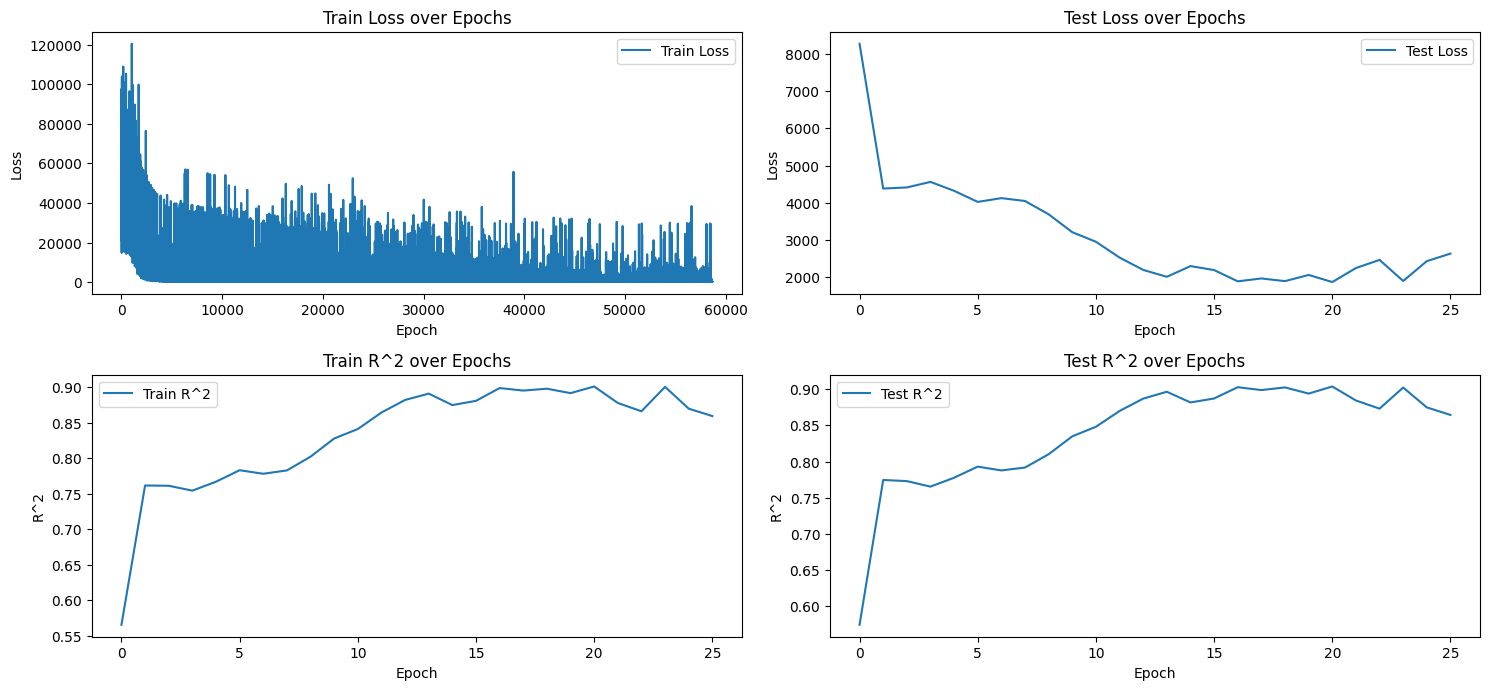

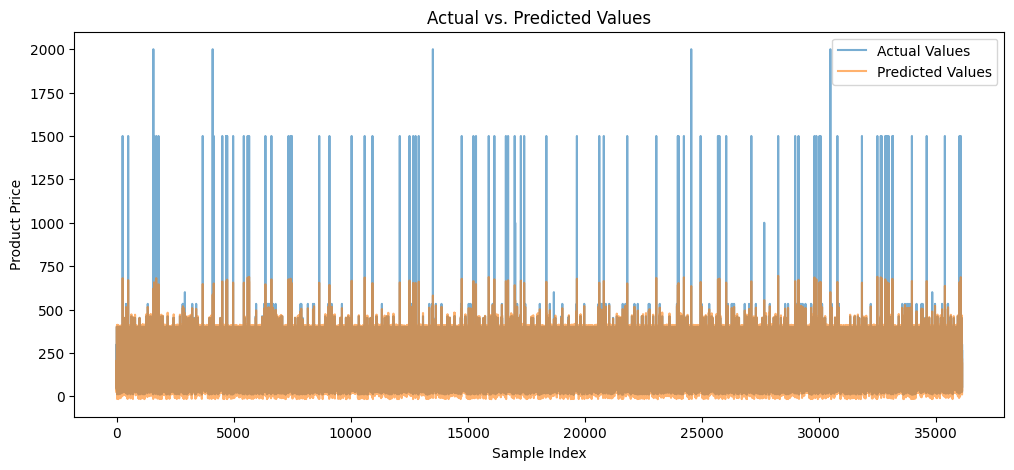

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import issparse
from torch.cuda.amp import autocast, GradScaler

# Load dataset
file_path = '/content/sample_data/DataCoSupplyChainDatasetCleaned.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preprocess the dataset
available_features = df.columns.tolist()
features = [
    'Sales per customer', 'Benefit per order', 'Product Category Id',
    'Product Name', 'Product Description', 'Customer Segment', 'Customer Country',
    'Customer City', 'Order Quantity', 'Shipping Mode', 'Order Status',
    'Delivery Status', 'Late_delivery_risk'
]

# Ensure only available features are included
features = [f for f in features if f in available_features]
target = 'Product Price'

# Separate numerical and categorical features
numerical_features = [f for f in features if df[f].dtype in ['int64', 'float64']]
categorical_features = [f for f in features if df[f].dtype == 'object']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Apply the preprocessing pipeline
print("Features being used:", features)
X = preprocessor.fit_transform(df[features])

# Convert sparse matrix to dense if needed
if issparse(X):
    X = X.toarray()

# Ensure the target column is available in the DataFrame
if target in df.columns:
    y = df[target].values
else:
    raise KeyError(f"Target column '{target}' not found in the DataFrame. Available columns: {df.columns.tolist()}")

# 4. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to GPU tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).view(-1, 1)

# Set batch size
batch_size = 64

# Transformer Model with Self-Attention
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_heads, num_layers, output_dim, dropout_rate):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_fc(x))
        x = self.dropout(x)
        x = self.transformer_encoder(x.unsqueeze(1)).squeeze(1)
        x = self.output_fc(x)
        return x

# Model Parameters
input_dim = X_train.shape[1]
hidden_dim = 32
n_heads = 4
num_layers = 2
output_dim = 1
dropout_rate = 0.5

# Initialize model
model = TransformerModel(input_dim, hidden_dim, n_heads, num_layers, output_dim, dropout_rate).to(device)

# 5. Train the Model Using Adam Optimizer
num_epochs = 50
train_loss_per_epoch = []
test_loss_per_epoch = []
train_r2_per_epoch = []
test_r2_per_epoch = []

optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scaler = GradScaler()  # Mixed precision training

train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train_tensor.cpu(), y_train_tensor.cpu())), batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=list(zip(X_test_tensor.cpu(), y_test_tensor.cpu())), batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=0)

# Training Loop
patience = 5
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        with autocast():
            y_pred_train = model(X_batch)
            train_loss = nn.MSELoss()(y_pred_train, y_batch)
        scaler.scale(train_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss_per_epoch.append(train_loss.item())

    # Calculate R-squared for training set
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        train_r2 = r2_score(y_train_tensor.cpu().numpy(), y_pred_train.cpu().numpy())
        train_r2_per_epoch.append(train_r2)

    # Evaluation on test set
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        test_loss = nn.MSELoss()(y_pred_test, y_test_tensor)
        test_loss_per_epoch.append(test_loss.item())

        # Calculate R-squared for test set
        test_r2 = r2_score(y_test_tensor.cpu().numpy(), y_pred_test.cpu().numpy())
        test_r2_per_epoch.append(test_r2)

        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}")

# 6. Predict Actual vs. Predicted Values
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_actual = y_test_tensor.cpu().numpy()

# 7. Visualize the Results
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.plot(train_loss_per_epoch, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(test_loss_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_r2_per_epoch, label='Train R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Train R^2 over Epochs')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(test_r2_per_epoch, label='Test R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Test R^2 over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Actual vs Predicted Plot
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Values', alpha=0.6)
plt.plot(y_pred, label='Predicted Values', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel(target)
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Individual: [384.90385332  45.21251525 223.29365806 ... 447.36037984  13.78792861
  60.26443648]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       384.903853
1         327.75        45.212515
2         327.75       223.293658
3         327.75       129.488382
4         327.75       429.539002


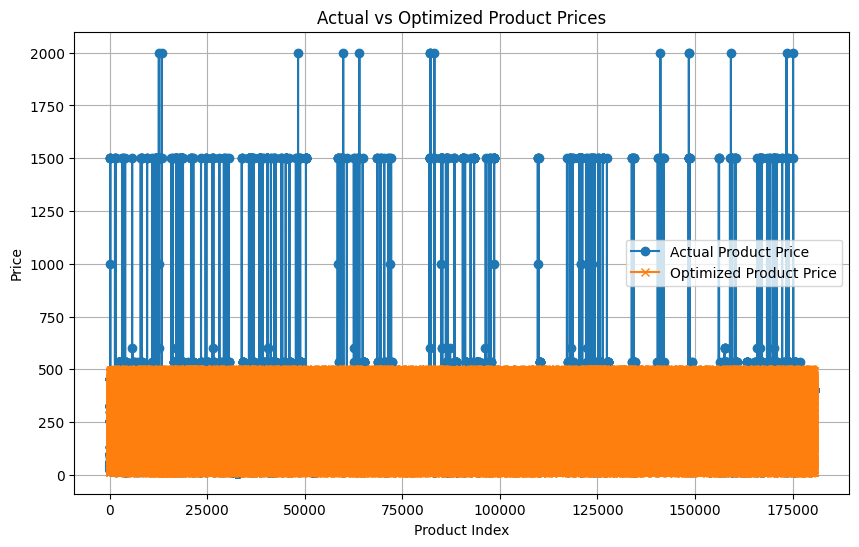

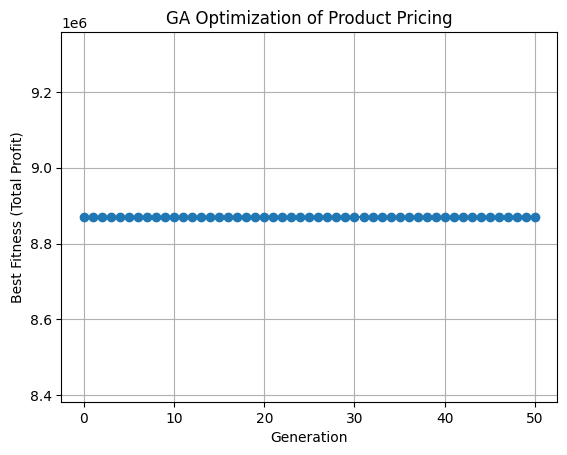

In [ ]:
import pandas as pd
import numpy as np
import pygad
import torch
import random
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return total_profit

# Fitness function to evaluate individuals
def fitness_function(ga_instance, solution, solution_idx):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# GA parameters
gene_space = {'low': 10, 'high': 500}  # Bounds for product prices

# Number of genes (one per product)
num_genes = len(df['Product Price'])

# Defining the GA instance
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=20,
    fitness_func=fitness_function,
    sol_per_pop=100,
    num_genes=num_genes,
    gene_space=gene_space,
    parent_selection_type="tournament",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    keep_parents=2
)

# Run the GA
ga_instance.run()

# Extract the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best Individual: {solution}")
print(f"Best Fitness (Total Profit): {solution_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the fitness over generations
plt.plot(ga_instance.best_solutions_fitness, marker='o')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Total Profit)')
plt.title('GA Optimization of Product Pricing')
plt.grid(True)
plt.show()

In [ ]:
!pip install pygmo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 15.2 MB/s eta 0:00:00


Best Individual: [126.46484532 416.0958147  308.15693088 ...  67.29244369 398.56654902
 278.03103218]
Best Fitness (Total Profit): 8870218.0
   Product Price  Optimized Price
0         327.75       126.464845
1         327.75       416.095815
2         327.75       308.156931
3         327.75       278.910980
4         327.75        89.151790


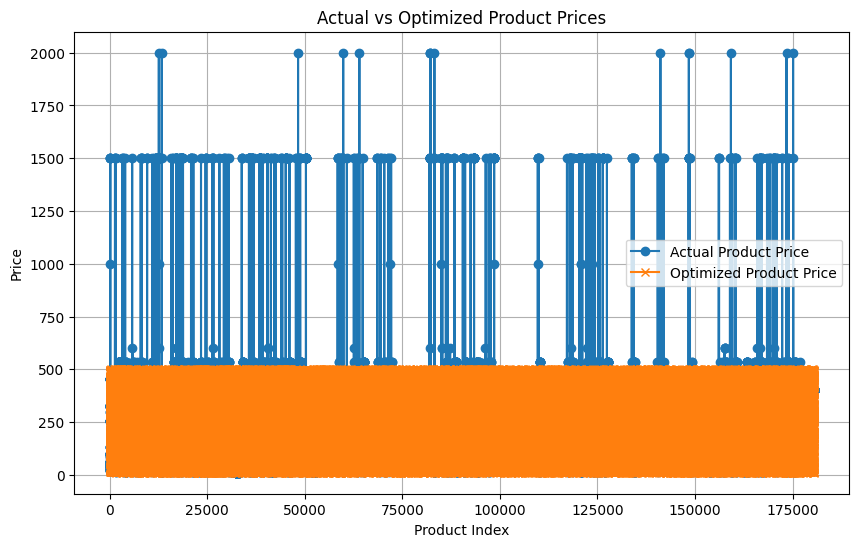

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pygmo as pg

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization

# Objective function for ABC
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# PyGMO problem definition
class ProductPricingProblem:
    def __init__(self):
        self.dim = len(df['Product Price'])
        self.bounds = ([10] * self.dim, [500] * self.dim)

    def fitness(self, x):
        return [fitness_function(x)]

    def get_bounds(self):
        return self.bounds

# Create the problem instance
problem = pg.problem(ProductPricingProblem())

# Create the ABC algorithm instance
algo = pg.algorithm(pg.bee_colony(gen=100))

# Create the population
population = pg.population(problem, size=50)

# Evolve the population
population = algo.evolve(population)

# Extract the best solution
best_solution = population.champion_x
best_fitness = population.champion_f[0]

# Print the best solution and its fitness
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-best_fitness}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install aco-pants

  Preparing metadata (setup.py) ... done
  Created wheel for aco-pants: filename=ACO_Pants-0.5.2-py3-none-any.whl size=18840 sha256=51afdfc0918052aa7d84d6efcd1c5a5d0b738fc40cae3e367dd0a8247ba0a3ea
  Stored in directory: /root/.cache/pip/wheels/18/20/45/4dc8bf8059c641765ecbbaf092ec25ad79f7deaa51662a68c8
Successfully built aco-pants


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pants import World, Solver

# Load dataset
df = pd.read_csv('/content/sample_data/DataCoSupplyChainDatasetCleaned.csv')

# Create 'Order_Demand' feature
# Assuming 'Order_Demand' can be derived from 'Order Item Quantity'
df['Order_Demand'] = df['Order Item Quantity']

# Create 'Product Category' feature
# Assuming 'Product Category' can be derived from 'Category Name'
df['Product Category'] = df['Category Name']

# Extract relevant features
df = df[['Product Price', 'Order_Demand', 'Sales per customer', 'Order Profit Per Order', 'Customer Segment', 'Product Category']]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function data using PyTorch
def calc_profit(product_prices, order_quantity, benefit_per_order):
    product_prices = torch.tensor(product_prices, dtype=torch.float32, device=device)
    order_quantity = torch.tensor(order_quantity, dtype=torch.float32, device=device)
    benefit_per_order = torch.tensor(benefit_per_order, dtype=torch.float32, device=device)

    total_profit = torch.sum(benefit_per_order * order_quantity).item()
    return -total_profit  # Negative for minimization

# Objective function for ACO
def fitness_function(solution):
    product_prices = solution
    order_quantity = df['Order_Demand'].values
    benefit_per_order = df['Order Profit Per Order'].values

    total_profit = calc_profit(product_prices, order_quantity, benefit_per_order)
    return total_profit

# ACO parameters
lb = 10  # Lower bound for product prices
ub = 500  # Upper bound for product prices
num_products = len(df['Product Price'])

# Define a distance function for ACO
def distance(a, b):
    # The "distance" here is the negative profit to maximize profit
    prices = np.linspace(lb, ub, num_products)
    solution = [prices[int(a[0])], prices[int(b[0])]]
    return fitness_function(solution)

# Create a world for ACO
coordinates = [(i, 0) for i in range(num_products)]  # Represent each product as a point
world = World(coordinates, distance)

# Solver setup
solver = Solver(rho=0.1, q=1.0, ant_count=50, steps=100)
solution = solver.solve(world)

# Extract the best solution
best_solution = [lb + (ub - lb) * coord[0] / num_products for coord in solution.tour]
print(f"Best Individual: {best_solution}")
print(f"Best Fitness (Total Profit): {-solution.length}")

# Compare actual product prices vs optimized product prices
df['Optimized Price'] = best_solution
comparison_df = df[['Product Price', 'Optimized Price']]
print(comparison_df.head())

# Plotting the actual vs optimized product prices
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Product Price'].values, label='Actual Product Price', marker='o')
plt.plot(comparison_df['Optimized Price'].values, label='Optimized Product Price', marker='x')
plt.xlabel('Product Index')
plt.ylabel('Price')
plt.title('Actual vs Optimized Product Prices')
plt.legend()
plt.grid(True)
plt.show()